# Volkov Vadim
# Multi-Class classification linear regression on the MNIST dataset.
## In this task we need to implement linear regression algorithm with the least squares approach, but on multiclass problem to the minst data set.
## I chose to implement an analytical solution of the least square approach using the normal equations we learned at the lectures and "Understanding Machine Learning: From Theory to Algorithms"

### Firstly we import all the needed libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
start_notebook_time = time.time()
from sklearn import metrics
from tqdm.notebook import tqdm
from numpy import linalg as la



### Secondly we will pull the data from the MNIST dataset and normalize the pixel value

In [ ]:
# Load MNIST dataset
mnist = fetch_openml("mnist_784", version = 1)
# Normalize the data
X, y = mnist.data, mnist.target.astype(int)
# scale the features for faster convergence
X /= 255

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# 1.Next we'll try to explore the data to see with what dimensions we're working with and how the data is structured

In [ ]:
X.shape

(70000, 784)

In [ ]:
y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: int64

(array([6903., 7877., 6990., 7141., 6824., 6313., 6876., 7293., 6825.,
        6958.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

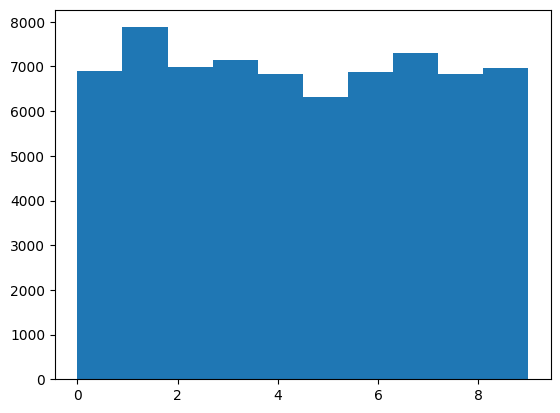

In [ ]:
# see the histogram of the digit occurance
plt.hist(y)

### Observe that the digit set is distributed almost uniformly

# 2. Organization of the data

## Before splitting the data we need some preperations

### 1'. add the bias term to the features (pixels):

In [ ]:
X = np.concatenate((np.ones(shape=(X.shape[0],))[:, np.newaxis], X), axis = 1)

In [ ]:
X.shape

(70000, 785)

### 2. Now splitting the pictures with the added bias term to the pixels and the 1-hot encoded predictions

In [ ]:
# Split the dataset into training and testing sets
num_of_train_samples = 60000
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=num_of_train_samples/len(X), shuffle = True)

### 3'. 1-hot encode the predictions:

In [ ]:
def encode_labels(y_set):
  num_classes = len(np.unique(y_set))
  encoded_labels = np.eye(num_classes)[y_set]
  return encoded_labels

In [ ]:
y_train_1hot = encode_labels(y_train)

In [ ]:
y_test_1hot = encode_labels(y_test)

# 4. Build the model

## 4.1. Implement the Multi-Class linear regression model

In [ ]:
class Liniear_Regression:

    # Init of the classes data structures and variables
    def __init__(self, X_train, y_train):
        self.num_features = X_train.shape[1] # 785
        self.num_classes = y_train.shape[1] # 10
        self.num_samples = X_train.shape[0] # 60000
        self.weights = NotImplementedError
        self.start_time = 0
        self.end_time = 0

    # Implmentation of the Multi-Class linear regression algorithm
    def fit(self, X_train, y_train):

        # Start timer for traning time
        self.start_time = time.time()

        # Check if the traning set is full rank
        is_X_train_full_rank = la.matrix_rank(X_train) == min(X_train.shape[0], X_train.shape[1])

        # If true use the normal equations with the to solve analytically, because X @ X.T is invertible so we can get its' inverse
        if is_X_train_full_rank:
          self.weights = np.linalg.inv(X_train.T @ X_train) @ (X_train.T @ y_train)
        # If false X @ X.T isnt invertible so we use the Moore–Penrose inverse matrix to solve the normal equations with the to solve analytically
        else:
          self.weights = np.linalg.pinv(X_train.T @ X_train) @ (X_train.T @ y_train)

        # End timer for traning time
        self.end_time = time.time()
        print("done")

    def train_time(self):
        print(str(int(self.end_time - self.start_time)) + " Seconds")

    def predict(self,x):
        raw_prediction = x @ self.weights
        return np.argmax(raw_prediction, axis = 1)

    def accuracy(self, predictions, y_test):
        return np.sum(predictions == y_test) / len(y_test)

    # plots the multi-class confusion matrix
    def conf_matrix(self, y_test ,y_prediction):
        cm = confusion_matrix(y_test,y_prediction)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
        cm_display.plot()
        cm_display.ax_.set_title("Multi-Class softmax Confusion Matrix")
        plt.show()

    def digit_stats(self, y_test, y_prediction):
        cm = confusion_matrix(y_test, y_prediction)
        #print digit stats
        for digit in range(10):

            #get stats
            TP = cm[digit][digit]
            FP = np.sum(cm[digit, :]) - TP
            FN = np.sum(cm[: ,digit]) - TP
            TN = np.sum(cm) - TP - FP - FN

            #calc metrics
            ACC = (TP+TN)/(TP+TN+FP+FN)
            TPR = TP/(TP+FN)
            TNR = TN/(TN+FP)

            #init confusion matrix and display metrics
            digit_i_cm = np.array([[TP, FP], [FN, TN]])
            digit_i_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = digit_i_cm, display_labels = [True, False])
            digit_i_cm_display.plot()
            #add title
            digit_i_cm_display.ax_.set_title(f"Class {digit} Confusion Matrix")
            #adds metrics
            digit_i_cm_display.ax_.text(-1, 2.2, f"ACC: {ACC:.3f} |")
            digit_i_cm_display.ax_.text(0, 2.2, f"TPR: {TPR:.3f} |")
            digit_i_cm_display.ax_.text(1, 2.2, f"TNR: {TNR:.3f}")
            #resizing the matrices
            digit_i_cm_display.figure_.set_figwidth(3)
            digit_i_cm_display.figure_.set_figheight(3)
            plt.show()

## 4.2.Initialize the model with the data

In [ ]:
model = Liniear_Regression(X_train, y_train_1hot)

## 4.3.Train the model

In [ ]:
model.fit(X_train, y_train_1hot)

done


## 4.4. Traning time duration

In [ ]:
model.train_time()

9 Seconds


# 5. Evaluation of the model

### 5.1. Make prediction on the test set

In [ ]:
y_prediction = model.predict(X_test)

### 5.2 Accuracy of the model's prediction

In [ ]:
model.accuracy(y_prediction, y_test)

0.8558

### 5.5 Confusion Matrix of the Multi-Class linear regression model

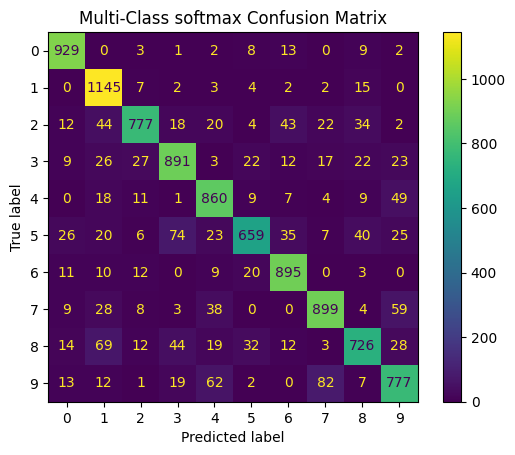

In [ ]:
model.conf_matrix(y_test,y_prediction)

### 5.6 Single Digit confusion matrix and metrics

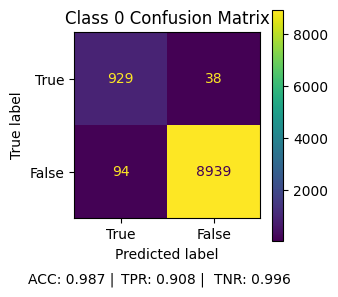

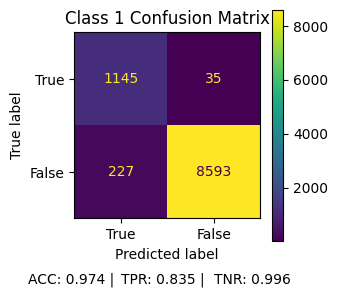

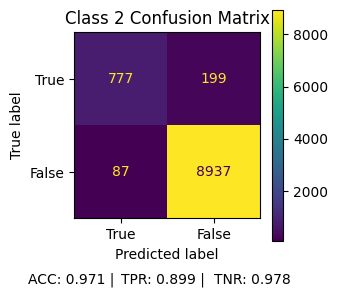

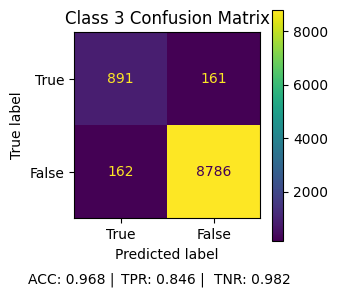

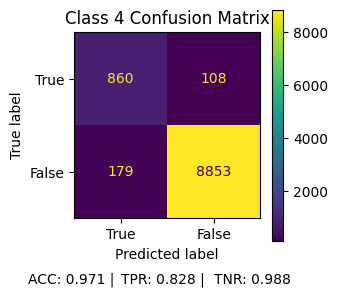

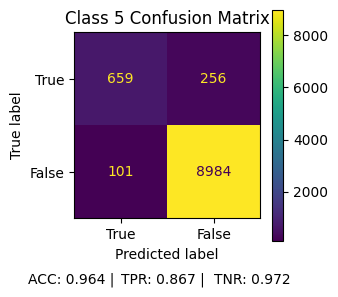

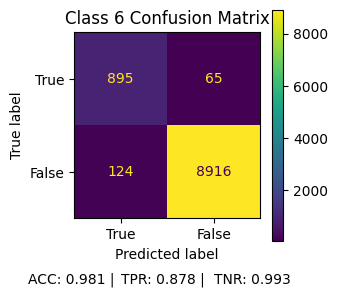

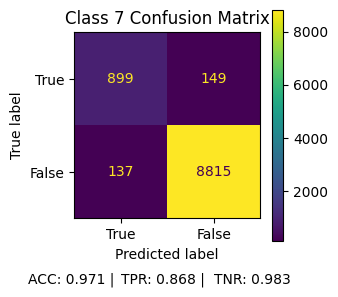

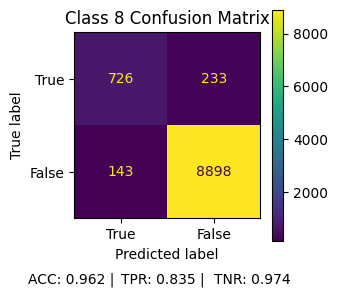

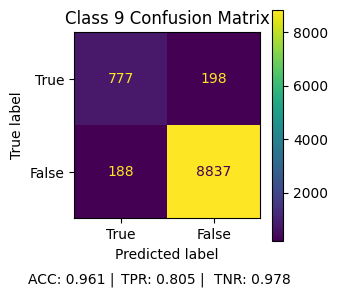

In [ ]:
model.digit_stats(y_test,y_prediction)

# Conclusion and discussion

In [ ]:

'''
Discussion of the results
-------------------------
I opted for a direct approach in dividing the training process into two scenarios.
Firstly, when the training matrix is full rank, one can promptly compute optimal weights using the normal equations, as we saw in class.
Secondly when the traning matrix isnt full rank we need to find A @ (X.T @ y) where A = V @ D+ @ V.T where V @ D @ V.T is the spectral decomposition of X.T @ X,
so instead to make the implementtaion a bit cleaner and understandle i used the Moore–Penrose inverse matrix to solve the normal equations

The training procedure of the linear regression model differs significantly from that of the perceptron and logistic regression models.
Drawing insights from the lectures about the topic and the "Understanding Machine Learning: From Theory to Algorithms" book,
the usage of the Mean Squared Error (MSE) loss function facilitates immediate solution determination through uncomplicated gradient calculations and identification of stationary vectors,
in contrast to the gradient descent required by the softmax function.

On a final note, linear regression's performance is inherently constrained by the nature of the data.
While primarily designed for regression tasks, such as predicting continuous values, it can be adapted for classification.
The linear regression model's expedient implementation and rapid execution make it advantageous for certain scenarios,
especially when compared to the more accurate but time-consuming gradient descent approach of logistic regression or pocket perceptron models.
'''

'\nDiscussion of the results\n-------------------------\nI opted for a direct approach in dividing the training process into two scenarios. \nFirstly, when the training matrix is full rank, one can promptly compute optimal weights using the normal equations, as we saw in class.\nSecondly when the traning matrix isnt full rank we need to find A @ (X.T @ y) where A = V @ D+ @ V.T where V @ D @ V.T is the spectral decomposition of X.T @ X,\nso instead to make the implementtaion a bit cleaner and understandle i used the Moore–Penrose inverse matrix to solve the normal equations\n\nThe training procedure of the linear regression model differs significantly from that of the perceptron and logistic regression models. \nDrawing insights from the lectures about the topic and the "Understanding Machine Learning: From Theory to Algorithms" book, \nthe usage of the Mean Squared Error (MSE) loss function facilitates immediate solution determination through uncomplicated gradient calculations and id